In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Alphabet import generic_protein
import re

In [2]:
# read in neut data

neut_file_path = '../data/VRC01_IC50_IC80.txt'

neuts = pd.read_table(neut_file_path, header=0)
neuts.rename(columns={'Virus name':'name', 
              'Subtype':'subtype',
              'VRC01: IC50 geometric mean':'IC50',
              'VRC01: IC80 geometric mean':'IC80'}, inplace=True)
# neuts.set_index('name', inplace=True)
neuts.drop(['Tier', 'Country', 'Accession', 'Alias', 'Seq data', 
            ' VRC01: IC50 by study', ' VRC01: IC80 by study', 'Unnamed: 11'], 
            axis=1, inplace=True)
neuts = neuts[neuts.name != 'Geometric mean of detected']
neuts = neuts[neuts.name != 'Geometric mean of all(undetected set to 100)'] 
neuts = neuts[neuts.name != '% detected (detected/total)'] 

In [3]:
# read in sequence data

virus_name = []
virus_seq = []
passed_seqs = []

fasta_file_path = '../data/VRC01 virus aa align.fasta'

for seq_record in SeqIO.parse(fasta_file_path, 'fasta', 
                              alphabet=generic_protein):
    try:
        virus_name.append(seq_record.id.split('.')[2])
        virus_seq.append(seq_record.seq)
    except:
        passed_seqs.append(seq_record)

HXB2 = passed_seqs[0]

In [4]:
# convert sequence data to DataFrame

seq_dict = {'sequence' : pd.Series(virus_seq, index=virus_name, 
                                   dtype='object')}
seq_df = pd.DataFrame(seq_dict)

In [5]:
# merge neuts and seq_df

neutdf = pd.merge(neuts, seq_df, how='inner', left_on='name', 
                    right_index=True)

In [6]:
# define neut categories

def binarize_IC50(row):
    if '>' in row.IC50:
        return 0
    else:
        value = float(row.IC50)
        return 0 if value > 50 else 1

neutdf['is_neutralized'] = neutdf.apply(binarize_IC50, axis=1)


In [9]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized
0,0013095_2_11,C,0.12352,0.46893,"(M, R, V, K, G, -, I, L, R, N, Y, -, Q, Q, W, ...",1
1,001428_2_42,C,0.02057,0.06234,"(M, R, V, R, G, -, I, L, R, N, Y, -, Q, Q, W, ...",1
2,0077_V1_C16,C,1.03134,1.79126,"(M, R, V, M, G, -, S, M, R, N, C, -, Q, R, W, ...",1
3,00836_2_5,C,0.15389,0.78049,"(M, R, V, R, G, -, I, R, R, N, Y, -, Q, H, W, ...",1
4,0260_V5_C36,A1,0.61196,1.70134,"(M, R, V, M, G, -, I, Q, R, N, S, -, Q, C, F, ...",1


# Feature Extraction

    Tokenize sequences w/ position value and amino acid identity
    Tokenize PNGS sites with a regex
    Vectorize tokens and create dataframe of dummy variables
    

In [10]:
# define function to tokenize sequence
# input = sequence object, output = dictionary where index is position and
# token is amino acid identity at that position

amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def sequence_tokenizer(seq):
    """
    
    """
    seq_list = list(str(seq).strip('*'))
    working_peptide = list(enumerate(seq_list, start=1))
    peptide_dict = {}
    for index, amino in working_peptide:
        if amino in amino_acids:
            peptide_dict.update({index : amino})
        else: 
            pass
    return peptide_dict


In [11]:
# define function to tokenize potential N-linked glycosylation sites 
# (PNGS) in sequence
# input = sequence object, output = dictionary where index is position
# and token = 'PNGS'

def PNGS_tokenizer(seq):
    seq_string = str(seq).strip('*')
    PNGS_dict = {m.start(0)+1 : 'PNGS' 
                for m in re.finditer(r"N[^P][ST]", seq_string)}
    return PNGS_dict


In [12]:
# define feature extraction function where input = seq object and 
# output = one dictionary of all features

def get_features(seq, use_positions=True, use_PNGS=True):
    features = {}
    if use_positions:
        sequence_features = sequence_tokenizer(seq)
        features.update(sequence_features)
    if use_PNGS:
        PNGS_features = PNGS_tokenizer(seq)
        features.update(PNGS_features)
    return features


In [13]:
# map get_features function to sequence column of neutdf

neutdf['features_dict'] = neutdf.sequence.map(get_features)


In [14]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized,features_dict
0,0013095_2_11,C,0.12352,0.46893,"(M, R, V, K, G, -, I, L, R, N, Y, -, Q, Q, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'K', 5: u'G', ..."
1,001428_2_42,C,0.02057,0.06234,"(M, R, V, R, G, -, I, L, R, N, Y, -, Q, Q, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
2,0077_V1_C16,C,1.03134,1.79126,"(M, R, V, M, G, -, S, M, R, N, C, -, Q, R, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'M', 5: u'G', ..."
3,00836_2_5,C,0.15389,0.78049,"(M, R, V, R, G, -, I, R, R, N, Y, -, Q, H, W, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
4,0260_V5_C36,A1,0.61196,1.70134,"(M, R, V, M, G, -, I, Q, R, N, S, -, Q, C, F, ...",1,"{1: u'M', 2: u'R', 3: u'V', 4: u'M', 5: u'G', ..."


In [17]:
# vectorize data and build feature df

from sklearn.feature_extraction import DictVectorizer

d_vect = DictVectorizer()

list_features = list(neutdf.features_dict)
sparse_features = d_vect.fit_transform(list_features)
name_features = d_vect.get_feature_names()

features_df = pd.DataFrame(sparse_features.toarray(), columns=name_features)

features_df.head()

,1000=F,1000=I,1000=L,1000=Q,1000=V,1001=Q,100=E,101=I,101=K,101=L,...,99=N,99=Q,99=R,99=Y,9=K,9=M,9=N,9=R,9=S,9=T
0,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [18]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[456]

561

In [19]:
# Examine features at positions 665 & 667 (MSA: 789 & 791)

epitope_features = [col for col in features_df.columns if '561' in col]
print epitope_features

['561=L', '561=M', '561=N', '561=R', '561=S', '561=V', '561=W', '561=Y']


# Feature Selection

    Trim down feature outliers (highly conserved sequences & single variants)
    Other feature selection approaches (mRMR, incorporated methods)

In [20]:
feature_counts = np.sum(features_df, axis=0)/features_df.shape[0]

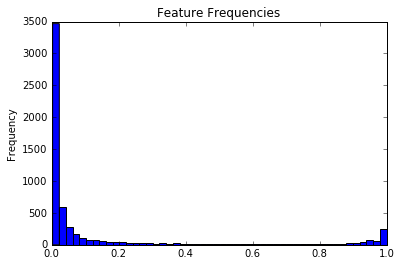

In [21]:
import matplotlib as plt
% matplotlib inline

feature_counts.plot.hist(title='Feature Frequencies', bins=50)

In [22]:
# define function to drop features that are shared by less than X% of sequences and/or more
# than 1-X% of sequences

def trim_feature_extremes(dataframe, percent_to_trim):
    total_rows = dataframe.shape[0]
    upper_threshold = (1 - percent_to_trim) * total_rows
    lower_threshold = percent_to_trim * total_rows
    column_filter_list = list((dataframe.sum(axis=0) >= lower_threshold) &
                                (dataframe.sum(axis=0) < upper_threshold)) 
                                #True = keep, False = drop
    column_filter_dict = zip(list(dataframe.columns), column_filter_list)
    columns_to_keep = [column for column, keepornot in column_filter_dict 
                        if keepornot == True]
    output_df = dataframe[columns_to_keep]
    return output_df
 

In [23]:
trimmed_features_df = trim_feature_extremes(features_df, 0.05)

trimmed_features_df.shape

(359, 1405)

# Build Decision Tree Classifier

    Use for feature selection


In [24]:
# define X & y as whole feature set without trimming features

X = features_df
y = neutdf.is_neutralized


In [25]:
# calculate best depth using roc_auc score

from sklearn.tree import DecisionTreeClassifier

max_depth_range = range(1, 101)

roc_auc_scores = []

from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclass = DecisionTreeClassifier(max_depth=depth)
    score = cross_val_score(treeclass, X, y, scoring='roc_auc', cv=10)
    roc_auc_scores.append(np.mean(score))
    
print roc_auc_scores

[0.63928571428571435, 0.60398056923918997, 0.60364668856048165, 0.64534482758620693, 0.63754789272030643, 0.67517651888341546, 0.65565681444991797, 0.65691570881226047, 0.65382868089764634, 0.68040640394088681, 0.65026546250684192, 0.6129406130268199, 0.66783524904214553, 0.6534674329501915, 0.65825670498084299, 0.65798850574712653, 0.68905582922824304, 0.66793103448275859, 0.72298850574712648, 0.65899835796387518, 0.68971264367816087, 0.67281609195402292, 0.69304597701149429, 0.69316912972085398, 0.66710180623973725, 0.67733169129720849, 0.70549261083743853, 0.64614942528735642, 0.65971264367816096, 0.69626436781609202, 0.65888341543513951, 0.66471264367816085, 0.69632183908045975, 0.69298850574712645, 0.70738916256157647, 0.67471264367816108, 0.66793103448275848, 0.66126436781609199, 0.6779310344827586, 0.65804597701149425, 0.68394088669950748, 0.67399835796387531, 0.68143678160919552, 0.68227422003284066, 0.6773316912972086, 0.68465517241379303, 0.65626436781609199, 0.68060755336617

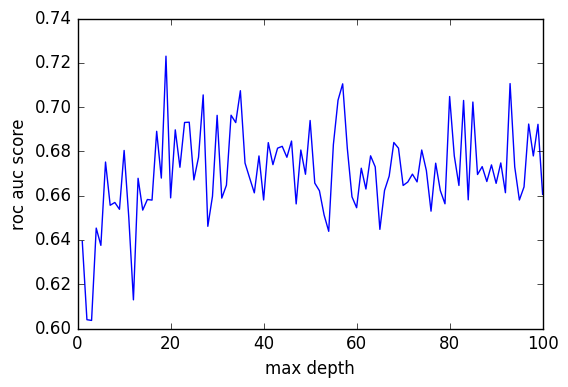

In [26]:
# graph roc_auc_scores vs max depth

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(max_depth_range, roc_auc_scores)
plt.xlabel('max depth')
plt.ylabel('roc auc score')

plt.rcdefaults()

In [27]:
sorted(zip(roc_auc_scores, max_depth_range), reverse=True)[0]

(0.72298850574712648, 19)

In [28]:
# fit tree using max depth of 3

treeclass = DecisionTreeClassifier(max_depth=20)
treeclass.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [40]:
# get feature importances

feat_import = pd.DataFrame({'feature': features_df.columns, 'importance': treeclass.feature_importances_})
feat_import.sort_values('importance', ascending=False).head(10)

,feature,importance
3652,561=R,0.283252
3904,592=I,0.083387
1973,372=S,0.081425
627,171=A,0.068659
1012,211=R,0.067711
4540,755=D,0.047022
804,187=Y,0.037919
4076,633=D,0.036646
2542,43=G,0.036161
4846,808=F,0.035685


In [41]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[471]

592

In [42]:
# look at other feature importances at same sites

features_561 = [feat for feat in feat_import.feature if '561' in feat]
features_592 = [feat for feat in feat_import.feature if '592' in feat]

In [43]:
feat_import.set_index('feature', inplace=True)
import_feat = feat_import.transpose()
import_feat[features_561]

feature,561=L,561=M,561=N,561=R,561=S,561=V,561=W,561=Y
importance,0,0,0,0.283252,0,0,0,0


In [44]:
import_feat[features_592]

feature,592=A,592=E,592=G,592=I,592=L,592=Q,592=S,592=T,592=V
importance,0,0,0,0.083387,0,0,0,0,0


# Build Random Forest
    
    Use randomized grid search CV for n_estimators, max_features

In [45]:
# import random forest classifier & define X & y using trimmed dataframe

from sklearn.ensemble import RandomForestClassifier

rfclass = RandomForestClassifier()

X = trimmed_features_df
y = neutdf.is_neutralized

In [46]:
from sklearn.grid_search import RandomizedSearchCV

estimators_range = range(0, 1501, 10)
feature_range = range(0, 501)

In [47]:
param_dist = dict(n_estimators=estimators_range, max_features=feature_range)
rand = RandomizedSearchCV(rfclass, param_dist, n_iter=50, scoring='roc_auc', cv=5)
rand.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, ...40, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='roc_auc', verbose=0)

In [49]:
grid = pd.DataFrame(rand.grid_scores_).sort_values('mean_validation_score', ascending=False)
grid.head(50)

,parameters,mean_validation_score,cv_validation_scores
19,"{u'n_estimators': 150, u'max_features': 208}",0.801705,"[0.798076923077, 0.794444444444, 0.65625, 0.80..."
0,"{u'n_estimators': 160, u'max_features': 52}",0.800049,"[0.848717948718, 0.78125, 0.565972222222, 0.81..."
35,"{u'n_estimators': 50, u'max_features': 394}",0.793464,"[0.75641025641, 0.754861111111, 0.780555555556..."
44,"{u'n_estimators': 880, u'max_features': 180}",0.793185,"[0.8, 0.774305555556, 0.627777777778, 0.817796..."
45,"{u'n_estimators': 270, u'max_features': 236}",0.792950,"[0.765384615385, 0.788194444444, 0.68402777777..."
49,"{u'n_estimators': 560, u'max_features': 213}",0.791573,"[0.814743589744, 0.790277777778, 0.6125, 0.800..."
27,"{u'n_estimators': 630, u'max_features': 61}",0.789918,"[0.833974358974, 0.792361111111, 0.57361111111..."
26,"{u'n_estimators': 1330, u'max_features': 107}",0.788725,"[0.789743589744, 0.793055555556, 0.60833333333..."
5,"{u'n_estimators': 520, u'max_features': 233}",0.787577,"[0.760897435897, 0.786805555556, 0.67013888888..."
40,"{u'n_estimators': 1270, u'max_features': 265}",0.787114,"[0.765384615385, 0.788888888889, 0.62916666666..."


In [50]:
# look at best parameters

print rand.best_score_
print rand.best_params_

0.801704781378
{'n_estimators': 150, 'max_features': 208}


In [51]:
# fit random forest with best parameters

rfclass = RandomForestClassifier(n_estimators=150, max_features=200, oob_score=True)
rfclass.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=200, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [52]:
# look at feature importances

forest_features_import = pd.DataFrame({'feature': X.columns, 'importance': rfclass.feature_importances_})
forest_features_import.sort_values('importance', ascending=False).head(10)

,feature,importance
828,561=R,0.050728
829,564=G,0.047863
868,587=E,0.032295
413,359=N,0.016520
969,717=Q,0.012739
572,436=R,0.010606
248,222=L,0.010562
620,462=H,0.009628
1157,858=S,0.008681
1032,774=T,0.008164


In [67]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[280]

359

In [64]:
# oob score

rfclass.oob_score_

0.83561643835616439

# Fit Logistic Regression with best features

    Evaluate with different iterations of selected features
    

In [53]:
# define new df with selected features & perform train/test split

selected_features = ['561=R', '564=G', '587=E', '359=N', '717=Q', '436=R', '222=L', '462=H']
X = features_df[selected_features]
y = neutdf.is_neutralized

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)

In [54]:
# fit logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [55]:
# look at coefficients

print logreg.coef_

[[ 3.09087358  3.39156162  1.22495903  2.24117383 -1.55514653 -0.32399965
   1.63906945 -2.64579423]]


In [56]:
# evaluate log loss

from sklearn import metrics

y_pred_proba = logreg.predict_proba(X_test)
print metrics.log_loss(y_test, y_pred_proba)

0.337389282823


In [57]:
# evaluate MCC

y_pred_class = logreg.predict(X_test)
print metrics.matthews_corrcoef(y_test, y_pred_class)

0.632455532034


In [58]:
# do above with different feature combinations

feature_selections = [['561=R', '564=G', '587=E', '359=N', '717=Q', '436=R', '222=L', '462=H'], 
                      ['561=R', '564=G', '587=E', '359=N', '717=Q', '436=R', '222=L'], 
                      ['561=R', '564=G', '587=E', '359=N', '717=Q', '436=R'], 
                      ['561=R', '564=G', '587=E', '359=N', '717=Q'], ['561=R', '564=G', '587=E', '359=N'], 
                      ['561=R', '564=G', '587=E'], ['561=R', '564=G'], ['561=R']]

log_loss_scores = []
MCC_scores = []

for selection in feature_selections:
    X = features_df[selection]
    y = neutdf.is_neutralized
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, y_pred_proba)
    y_pred_class = logreg.predict(X_test)
    MCC = metrics.matthews_corrcoef(y_test, y_pred_class)
    log_loss_scores.append(log_loss)
    MCC_scores.append(MCC)

In [59]:
# make a dataframe of the above

log_reg_eval = pd.DataFrame({'features': feature_selections, 'log loss': log_loss_scores, 'MCC': MCC_scores})
log_reg_eval.sort_values('MCC', ascending=False)

,MCC,features,log loss
0,0.670855,"[561=R, 564=G, 587=E, 359=N, 717=Q, 436=R, 222...",0.265706
7,0.588672,[561=R],0.335701
3,0.584307,"[561=R, 564=G, 587=E, 359=N, 717=Q]",0.329674
6,0.553399,"[561=R, 564=G]",0.326327
1,0.542857,"[561=R, 564=G, 587=E, 359=N, 717=Q, 436=R, 222=L]",0.336885
4,0.506564,"[561=R, 564=G, 587=E, 359=N]",0.304261
5,0.457143,"[561=R, 564=G, 587=E]",0.343071
2,0.442719,"[561=R, 564=G, 587=E, 359=N, 717=Q, 436=R]",0.482627
